# Table of contents

1. [Load the dataset](#load_the_dataset)
2. [Split the dataset](#split_the_dataset)
3. [Fitting the recommender](#fitting)
4. [Sequential evaluation](#seq_evaluation)  
    4.1 [Evaluation with sequentially revaeled user profiles](#eval_seq_rev)  
    4.2 [Evaluation with "static" user profiles](#eval_static)  
5. [Analysis of next-item recommendation](#next-item)  
    5.1 [Evaluation with different recommendation list lengths](#next-item_list_length)  
    5.2 [Evaluation with different user profile lengths](#next-item_profile_length)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from util.data_utils import create_seq_db_filter_top_k, sequences_to_spfm_format
from util.split import random_holdout, temporal_holdout
from util.metrics import precision, recall, mrr
from util import evaluation
from recommenders.MixedMarkovRecommender import MixedMarkovChainRecommender

In [3]:
import datetime

In [4]:
def get_test_sequences(test_data, given_k):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    test_sequences = test_data.loc[test_data['sequence'].map(len) > abs(given_k), 'sequence'].values
    return test_sequences

<a id='load_the_dataset'></a>

# 1. Load the dataset

For this hands-on session we will use a dataset of user-listening sessions crawled from [last.fm](https://www.last.fm/). In detail, we will use a subset of the following dataset:

* 30Music listening and playlists dataset, Turrin et al., ACM RecSys 2015 ([paper](https://home.deib.polimi.it/pagano/portfolio/papers/30Musiclisteningandplaylistsdataset.pdf))

In [5]:
dataset_path = 'datasets/sessions.csv'

# for the sake of speed, let's keep only the top-5k most popular items 
dataset = create_seq_db_filter_top_k(path=dataset_path,
                                     topk=1000,
                                     last_months=1) 

/Users/mquadrana/workspace/sars_tutorial/util/data_utils.py:23: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  aggregated = groups['item_id'].agg({'sequence': lambda x: list(map(str, x))})


Let's see at how the dataset looks like

In [6]:
dataset.head()

,sequence,ts,user_id
session_id,,,
122,"[1762, 3700, 638]",1420059172,2432
223,"[3772, 3953]",1419418147,15861
226,"[245, 1271, 379]",1419433841,15861
243,"[245, 1197, 4307, 3868]",1421674741,15861
245,"[409, 234, 2334, 2431, 231, 4738, 219, 2403]",1421679507,15861


Let's show some statistics about the dataset

In [7]:
from collections import Counter
cnt = Counter()
dataset.sequence.map(cnt.update);

In [8]:
sequence_length = dataset.sequence.map(len).values
n_sessions_per_user = dataset.groupby('user_id').size()

print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(dataset.user_id.nunique()))
print('Number of sessions: {}'.format(len(dataset)) )

print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))

print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

Number of items: 1000
Number of users: 17816
Number of sessions: 65917

Session length:
	Average: 4.19
	Median: 3.0
	Min: 1
	Max: 198
Sessions per user:
	Average: 3.70
	Median: 3.0
	Min: 1
	Max: 38


In [9]:
print('Most popular items: {}'.format(cnt.most_common(5)))

Most popular items: [('443', 1970), ('1065', 1526), ('67', 1462), ('1622', 1212), ('2308', 1211)]


<a id='split_the_dataset'></a>

# 2. Split the dataset

For simplicity, let's split the dataset randomly. NOTE: Sessions will be assigned either to the training or the test set.

In [10]:
train_data, test_data = random_holdout(dataset, perc=0.8, seed=1234)

In [11]:
print("Train size: {} - Test size: {}".format(len(train_data), len(test_data)))

Train size: 52733 - Test size: 13184


<a id='fitting'></a>

# 3. Fitting the recommender

Here we fit the recommedation algorithm over the sessions in the training set.  
This recommender is based on the `MarkovChainRecommender` implemented from:

_Shani, Guy, David Heckerman, and Ronen I. Brafman. "An MDP-based recommender system."
    Journal of Machine Learning Research 6, no. Sep (2005): 1265-1295. Chapter 3-4_

The class `MixedMarkovChainRecommender` has the following initialization hyper-parameters:
* `min_order`: the minimum order of the Mixed Markov Chain
* `max_order`: the maximum order of the Mixed Markov Chain


In [12]:
recommender = MixedMarkovChainRecommender(min_order=1, 
                                          max_order=2)
recommender.fit(train_data)

2018-09-25 15:12:25,379 - INFO - Building Markov Chain model with k = 1
2018-09-25 15:12:25,380 - INFO - Adding nodes
2018-09-25 15:12:25,848 - INFO - Adding edges
2018-09-25 15:13:05,934 - INFO - Applying skipping
2018-09-25 15:13:10,712 - INFO - Applying clustering
2018-09-25 15:13:10,713 - INFO - 1000 states in the graph
2018-09-25 15:21:35,899 - INFO - Building Markov Chain model with k = 2
2018-09-25 15:21:35,900 - INFO - Adding nodes
2018-09-25 15:21:55,703 - INFO - Adding edges


KeyboardInterrupt: 

<a id='seq_evaluation'></a>


# 4. Sequential evaluation

In the evaluation of sequence-aware recommenders, each sequence in the test set is split into:
- the _user profile_, used to compute recommendations, is composed by the first *k* events in the sequence;
- the _ground truth_, used for performance evaluation, is composed by the remainder of the sequence.

In the cells below, you can control the dimension of the _user profile_ by assigning a **positive** value to `GIVEN_K`, which correspond to the number of events from the beginning of the sequence that will be assigned to the initial user profile. This ensures that each user profile in the test set will have exactly the same initial size, but the size of the ground truth will change for every sequence.

Alternatively, by assigning a **negative** value to `GIVEN_K`, you will set the initial size of the _ground truth_. In this way the _ground truth_ will have the same size for all sequences, but the dimension of the user profile will differ.

In [13]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
TOPN = 10 # length of the recommendation list

<a id='eval_seq_rev'></a>

## 4.1 Evaluation with sequentially revealed user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are revealed _sequentially_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  
The _user profile_ is next expanded to the next `STEP` events, the ground truth is scrolled forward accordingly, and the evaluation continues until the sequence ends.

In typical **next-item recommendation**, we start with `GIVEN_K=1`, generate a set of **alternatives** that will evaluated against the next event in the sequence (`LOOK_AHEAD=1`), move forward of one step (`STEP=1`) and repeat until the sequence ends.

You can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

NOTE: Metrics are averaged over each sequence first, then averaged over all test sequences.

** (TODO) Try out with different evaluation settings to see how the recommandation quality changes. **


![](gifs/sequential_eval.gif)

In [14]:
# GIVEN_K=1, LOOK_AHEAD=1, STEP=1 corresponds to the classical next-item evaluation
GIVEN_K = 1
LOOK_AHEAD = 1
STEP=1

In [15]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False,
                                           step=STEP)

  3%|▎         | 314/9323 [00:00<00:05, 1554.93it/s]

9323 sequences available for evaluation


100%|██████████| 9323/9323 [00:06<00:00, 1473.98it/s]


In [16]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@5: 0.0210
	recall@5: 0.1048
	mrr@5: 0.0532


<a id='eval_static'></a>

## 4.2 Evaluation with "static" user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are instead _static_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  

The user profile is *not extended* and the ground truth *doesn't move forward*.
This allows to obtain "snapshots" of the recommendation performance for different user profile and ground truth lenghts.

Also here you can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

**(TODO) Try out with different evaluation settings to see how the recommandation quality changes.**

In [17]:
GIVEN_K = 1
LOOK_AHEAD = 'all'
STEP=1

In [18]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False  # notice that scrolling is disabled!
                                          )  

  3%|▎         | 309/9323 [00:00<00:05, 1510.57it/s]

9323 sequences available for evaluation


100%|██████████| 9323/9323 [00:06<00:00, 1443.55it/s]


In [19]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=all, STEP=1)
	precision@5: 0.0596
	recall@5: 0.0826
	mrr@5: 0.1153


<a id='next-item'></a>

## 5. Analysis of next-item recommendation

Here we propose to analyse the performance of the recommender system in the scenario of *next-item recommendation* over the following dimensions:

* the *length* of the **recommendation list**, and
* the *length* of the **user profile**.

NOTE: This evaluation is by no means exhaustive, as different the hyper-parameters of the recommendation algorithm should be *carefully tuned* before drawing any conclusions. Unfortunately, given the time constraints for this tutorial, we had to leave hyper-parameter tuning out. A very useful reference about careful evaluation of (session-based) recommenders can be found at:

*  Evaluation of Session-based Recommendation Algorithms, Ludewig and Jannach, 2018 ([paper](https://arxiv.org/abs/1803.09587))

<a id='next-item_list_length'></a>

### 5.1 Evaluation for different recommendation list lengths

In [20]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1
topn_list = [1, 5, 10, 20, 50, 100]

In [21]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

9323 sequences available for evaluation


In [22]:
res_list = []

for topn in topn_list:
    print('Evaluating recommendation lists with length: {}'.format(topn))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=GIVEN_K,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=topn,
                                               scroll=True,  # here we average over all profile lengths
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((topn, mvalues))

  0%|          | 37/9323 [00:00<00:25, 369.17it/s]

Evaluating recommendation lists with length: 1


  0%|          | 38/9323 [00:00<00:46, 200.02it/s]

Evaluating recommendation lists with length: 5


  0%|          | 38/9323 [00:00<00:32, 282.48it/s]

Evaluating recommendation lists with length: 10


  0%|          | 38/9323 [00:00<00:31, 298.33it/s]

Evaluating recommendation lists with length: 20


  0%|          | 38/9323 [00:00<00:35, 262.68it/s]

Evaluating recommendation lists with length: 50


  0%|          | 36/9323 [00:00<00:26, 356.62it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 9323/9323 [00:33<00:00, 277.18it/s]


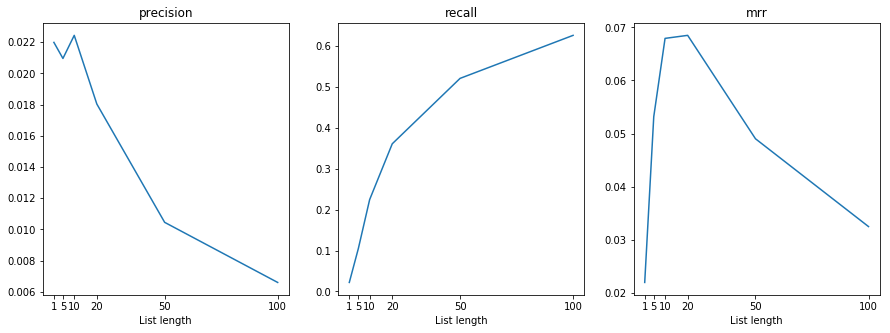

In [23]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(topn_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(topn_list)
    ax.set_xlabel('List length')

<a id='next-item_profile_length'></a>

### 5.2 Evaluation for different user profile lengths

In [24]:
given_k_list = [1, 2, 3, 4]
LOOK_AHEAD = 1
STEP = 1
TOPN = 20

In [25]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, max(given_k_list))
print('{} sequences available for evaluation'.format(len(test_sequences)))

3867 sequences available for evaluation


In [26]:
res_list = []

for gk in given_k_list:
    print('Evaluating profiles having length: {}'.format(gk))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=gk,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=TOPN,
                                               scroll=False,  # here we stop for each sequence length
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((gk, mvalues))

  1%|          | 25/3867 [00:00<00:16, 236.62it/s]

Evaluating profiles having length: 1


  4%|▎         | 145/3867 [00:00<00:02, 1448.05it/s]

Evaluating profiles having length: 2


  4%|▍         | 161/3867 [00:00<00:02, 1607.80it/s]

Evaluating profiles having length: 3


  8%|▊         | 311/3867 [00:00<00:02, 1539.93it/s]

Evaluating profiles having length: 4


100%|██████████| 3867/3867 [00:02<00:00, 1538.58it/s]


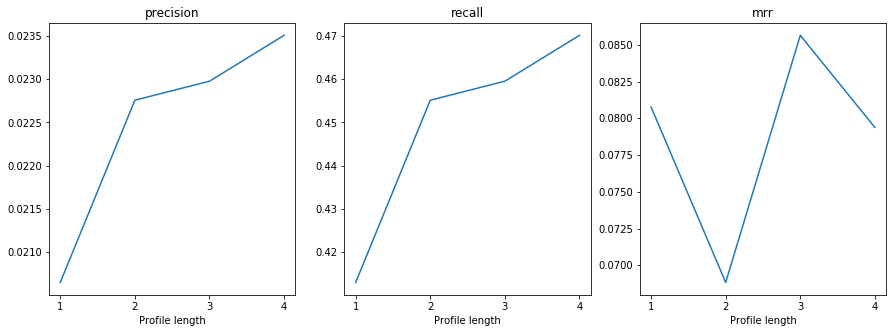

In [27]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(given_k_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(given_k_list)
    ax.set_xlabel('Profile length')